In [2]:
import contextily as cx
import figure_utilities
import figure_and_table_constants
import constants
from stats_utilities import produce_summary_statistics, select_controls, test_balance
import geopandas as gpd
import matplotlib.pyplot as plt
from panel_utilities import get_value_variable_names, prepare_df_for_DiD
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import os
from differences import ATTgt, TWFE
import pandas as pd

# Store paths.
INPUT_DATA_PANEL = "../../data/03_cleaned/crime_analysis_monthly.parquet"
INPUT_DATA_TRACTS = "../../data/02_intermediate/tracts.csv"
INPUT_DATA_BOSTON_TRACTS_SHAPEFILE = "../../data/01_raw/Census_2010_Tracts"

OUTPUT_TABLES = "../../output/final_paper/tables"
OUTPUT_FIGURES = "../../output/final_paper/figures"

# Read unrestricted dataset into memory.
df = pd.read_parquet(INPUT_DATA_PANEL)

# So we can use 'case_number' like a column
df = df.reset_index()

/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/lm/j45l41m16cs8sd5r9sh4gj6w0000gn/T/ipykernel_4560/3317769234.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from P

# Summary Statistics

In [ ]:
# Plot evictions spatially.
unrestricted_gdf = gpd.GeoDataFrame(df,
                                    geometry=gpd.points_from_xy(df['Longitude'],
                                                                df['Latitude']))
unrestricted_gdf = unrestricted_gdf.set_crs("EPSG:4326")
unrestricted_gdf = unrestricted_gdf.to_crs("EPSG:3857")
fig, ax = plt.subplots(figsize=(7, 9))
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xticks([])
unrestricted_gdf.plot(ax=ax,
                      color='black',
                      markersize=0.05)
cx.add_basemap(ax=ax, crs="EPSG:3857", source=cx.providers.Stamen.TonerLite)

# Color census tracts by poverty rate.
boston_tracts_gdf = gpd.read_file(INPUT_DATA_BOSTON_TRACTS_SHAPEFILE)[['GEOID10', 'geometry']].set_index('GEOID10')
boston_tracts_gdf.index = boston_tracts_gdf.index.astype(int)
tract_poverty_rates_df = pd.read_csv(INPUT_DATA_TRACTS, usecols=['tract_geoid', 'poor_share2010'], index_col='tract_geoid')

boston_tracts_gdf = pd.concat([boston_tracts_gdf, tract_poverty_rates_df], axis=1).dropna(subset=['geometry', 'poor_share2010'])
boston_tracts_gdf.plot(ax=ax, column=boston_tracts_gdf['poor_share2010'], cmap='OrRd', alpha=0.4, legend=True, legend_kwds={'label': "Poverty Rate of Census Tract",
                                                                                                                            'orientation': "horizontal",
                                                                                                                            'shrink': 0.25})



figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "evictions_map.png"))

In [ ]:
# Plot the number of eviction filings over time.
df.loc[:, 'last_day_of_file_month'] = (pd.to_datetime(df['file_date']) +
                                       pd.tseries.offsets.MonthEnd(0))
filings_per_month = df.groupby('last_day_of_file_month')['case_number'].count()

# Plot eviction filing counts.
fig, ax = plt.subplots()
filings_per_month.plot(ax=ax, kind='line', color=figure_and_table_constants.Colors.SUMMARY_STATISTICS_COLOR,
                       zorder=100)
ax.set_ylabel("Number of Evictions")
ax.set_xlabel("Month")
ax.grid(True)


figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "filings_over_time.png"))

In [ ]:
# Produce summary statistics table.
treatment_date_variable = 'latest_docket_date'
outcomes_of_interest = ['group_0_crimes_500m']
summary_statistics_unrestricted, variable_display_names_dict  = produce_summary_statistics(df,
                                                                                           treatment_date_variable=treatment_date_variable)

# Rename columns.
summary_statistics_unrestricted.index = summary_statistics_unrestricted.index.set_names(["Panel", "Variable"])
column_display_names_dict = {'mean': "Mean", 'std': "S.D.", 'count': "N", '50%': 'Median'}

summary_statistics_unrestricted = summary_statistics_unrestricted.sort_values(['Panel', 'Variable'])
# Keep only outcomes of interest
outcomes = constants.Variables.outcomes.copy()
for outcome in outcomes:
    if outcome not in outcomes_of_interest:
        if f"pre_treatment_change_in_{outcome}" in summary_statistics_unrestricted.index.get_level_values(1):
            summary_statistics_unrestricted = summary_statistics_unrestricted.drop(f"pre_treatment_change_in_{outcome}", level=1, axis=0)
        if f"total_twenty_seventeen_{outcome}" in summary_statistics_unrestricted.index.get_level_values(1):
            summary_statistics_unrestricted = summary_statistics_unrestricted.drop(f"total_twenty_seventeen_{outcome}", level=1, axis=0)

# Drop Panel F.
summary_statistics_unrestricted = summary_statistics_unrestricted.drop("Panel F: Post-treatment Outcomes", level=0, axis=0)

# Drop median column.
summary_statistics_unrestricted = summary_statistics_unrestricted.drop(columns='50%')


# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "summary_statistics.tex")
latex = (summary_statistics_unrestricted
         .rename(index=variable_display_names_dict)
         .rename(columns=column_display_names_dict)
         .style
         .format(formatter={
    'Mean': "{:,.2f}",
    'Median': "{:,.2f}",
    'S.D.': "{:,.2f}",
    'N': "{:,.0f}"})
         .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
         .to_latex(None,
                   column_format="llcccc",
                   hrules=True,
                   clines="skip-last;data")).replace("{*}", "{4cm}")
with open(filename, 'w') as file:
    file.write(latex)
summary_statistics_unrestricted

In [ ]:
# Produce treatment timings table.
treatment_timings = (df
                     .groupby(['latest_docket_month', 'judgment_for_plaintiff'])['case_number']
                     .count()
                     .reset_index()
                     .fillna(0))
treatment_timings = treatment_timings.pivot(index='latest_docket_month', columns='judgment_for_plaintiff').fillna(0)
treatment_timings.columns = ["Cases Won By Defendant", "Cases Won By Plaintiff"]
portion_of_all_cases = (treatment_timings['Cases Won By Plaintiff'] + treatment_timings['Cases Won By Defendant']) / len(df)
treatment_timings = pd.concat([treatment_timings, portion_of_all_cases.rename('Portion of All Cases')], axis=1)
sum_across_filing_date = pd.DataFrame(treatment_timings.sum(axis=0)).T
sum_across_filing_date.index = ["All Months"]
treatment_timings = pd.concat([sum_across_filing_date, treatment_timings], axis=0)
treatment_timings.index = treatment_timings.index.rename("Last Docket Date")

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "treatment_timings.tex")
treatment_timings.style.format(formatter={'Cases Won By Plaintiff': '{:,.0f}',
                                          'Cases Won By Defendant': '{:,.0f}',
                                          'Portion of All Cases': '{:0.2f}'}).to_latex(filename, column_format="lccc", hrules=True)
treatment_timings

In [ ]:
# Calculate percent of cases which are in high poverty neighborhoods.
df = df.loc[df['judgment_for_plaintiff'] == 1, :]
original_N = len(df)
cases_in_poor_tracts = len(df.loc[df['poor_share2010'] > 0.20, :])
cases_in_poor_tracts / original_N

# Main Results

In [ ]:
# Read fresh copy of unrestricted dataset into memory.
df = pd.read_parquet(INPUT_DATA_PANEL)
treatment_date_variable = 'latest_docket_month'  # Store treatment date variable.
analysis = 'group_0_crimes_500m'

In [ ]:
# Generate value variables list and dictionaries mapping between months and integers.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [ ]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            output_directory=OUTPUT_TABLES)
covariates_exploration_df

In [ ]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

In [ ]:
# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [ ]:
# Run DiD conditional on covariates.
att_gt_all_crimes = ATTgt(data=df, cohort_name=treatment_date_variable, base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt_all_crimes.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)

In [ ]:
print(att_gt_all_crimes.aggregate('event', 'all')['EventAggregationOverall'].iloc[0, 2])

In [ ]:
# Plot D.R. ATT(t-g)s on a long horizon.
fig, ax = plt.subplots(layout='constrained')
figure_utilities.aggregate_by_event_time_and_plot(att_gt_all_crimes, start_period=-6,
                                                  end_period=36,
                                                  title="", ax=ax)

figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_all_crimes.png"))


# Heterogenous Impacts

In [3]:
# Check for heterogeneous treatment effects.
subsample_variables = ['poor_share2010', 'share_white2010', 'popdensity2010']
# Read fresh copy of unrestricted dataset into memory.
df = pd.read_parquet(INPUT_DATA_PANEL)
treatment_date_variable = 'latest_docket_month'  # Store treatment date variable.
analysis = 'group_0_crimes_500m'
point_estimates = []
ci_uppers = []
ci_lowers = []

for subsample_variable in subsample_variables:
    # Get results on below median subsample.
    below_median_subsample = df[df[subsample_variable] < df[subsample_variable].median()].copy()
    weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(below_median_subsample, analysis)
    covariates_exploration_df = select_controls(df=below_median_subsample, analysis=analysis, treatment_date_variable=treatment_date_variable)
    balance_table, pre_treatment_covariates = test_balance(below_median_subsample, analysis, covariates_exploration_df)
    below_median_subsample = below_median_subsample.reset_index()
    below_median_subsample = prepare_df_for_DiD(df=below_median_subsample,
                                                analysis=analysis,
                                                treatment_date_variable=treatment_date_variable,
                                                pre_treatment_covariates=pre_treatment_covariates,
                                                missing_indicators=[],
                                                value_vars=weekly_value_vars_crime,
                                                period_to_int_dictionary=month_to_int_dictionary)
    # Run DiD conditional on covariates.
    att_gt_below_median = ATTgt(data=below_median_subsample, cohort_name=treatment_date_variable, base_period='universal')
    formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
    att_gt_below_median.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)
    average_post_treatment_att_below_median = att_gt_below_median.aggregate('event', overall=True)
    point_estimate_below_median = round(average_post_treatment_att_below_median['EventAggregationOverall'].iloc[0, 0], 2)
    ci_upper_below_median = round(average_post_treatment_att_below_median['EventAggregationOverall'].iloc[0, 3], 2)
    ci_lower_below_median = round(average_post_treatment_att_below_median['EventAggregationOverall'].iloc[0, 2], 2)
    point_estimates.append(point_estimate_below_median)
    ci_uppers.append(ci_upper_below_median)
    ci_lowers.append(ci_lower_below_median)

    # Get results on above median subsample.
    above_median_subsample = df[df[subsample_variable] > df[subsample_variable].median()].copy()
    weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(above_median_subsample, analysis)
    covariates_exploration_df = select_controls(df=above_median_subsample, analysis=analysis, treatment_date_variable=treatment_date_variable)
    balance_table, pre_treatment_covariates = test_balance(above_median_subsample, analysis, covariates_exploration_df)
    above_median_subsample = above_median_subsample.reset_index()
    above_median_subsample = prepare_df_for_DiD(df=above_median_subsample,
                            analysis=analysis,
                            treatment_date_variable=treatment_date_variable,
                            pre_treatment_covariates=pre_treatment_covariates,
                            missing_indicators=[],
                            value_vars=weekly_value_vars_crime,
                            period_to_int_dictionary=month_to_int_dictionary)
    # Run DiD conditional on covariates.
    att_gt_above_median = ATTgt(data=above_median_subsample, cohort_name=treatment_date_variable, base_period='universal')
    formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
    att_gt_above_median.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)
    average_post_treatment_att_above_median = att_gt_above_median.aggregate('event', overall=True)
    point_estimate_above_median = round(average_post_treatment_att_above_median['EventAggregationOverall'].iloc[0, 0], 2)
    ci_upper_above_median = round(average_post_treatment_att_above_median['EventAggregationOverall'].iloc[0, 3], 2)
    ci_lower_above_median = round(average_post_treatment_att_above_median['EventAggregationOverall'].iloc[0, 2], 2)
    point_estimates.append(point_estimate_above_median)
    ci_uppers.append(ci_upper_above_median)
    ci_lowers.append(ci_lower_above_median)






Computing ATTgt [workers=10]    0%|                    | 0/1012 [00:00<?, ?it/s]/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
Computing ATTgt [workers=10]    0%|                    | 1/1012 [00:06<1:53:52,  6.76s/it]/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-pa

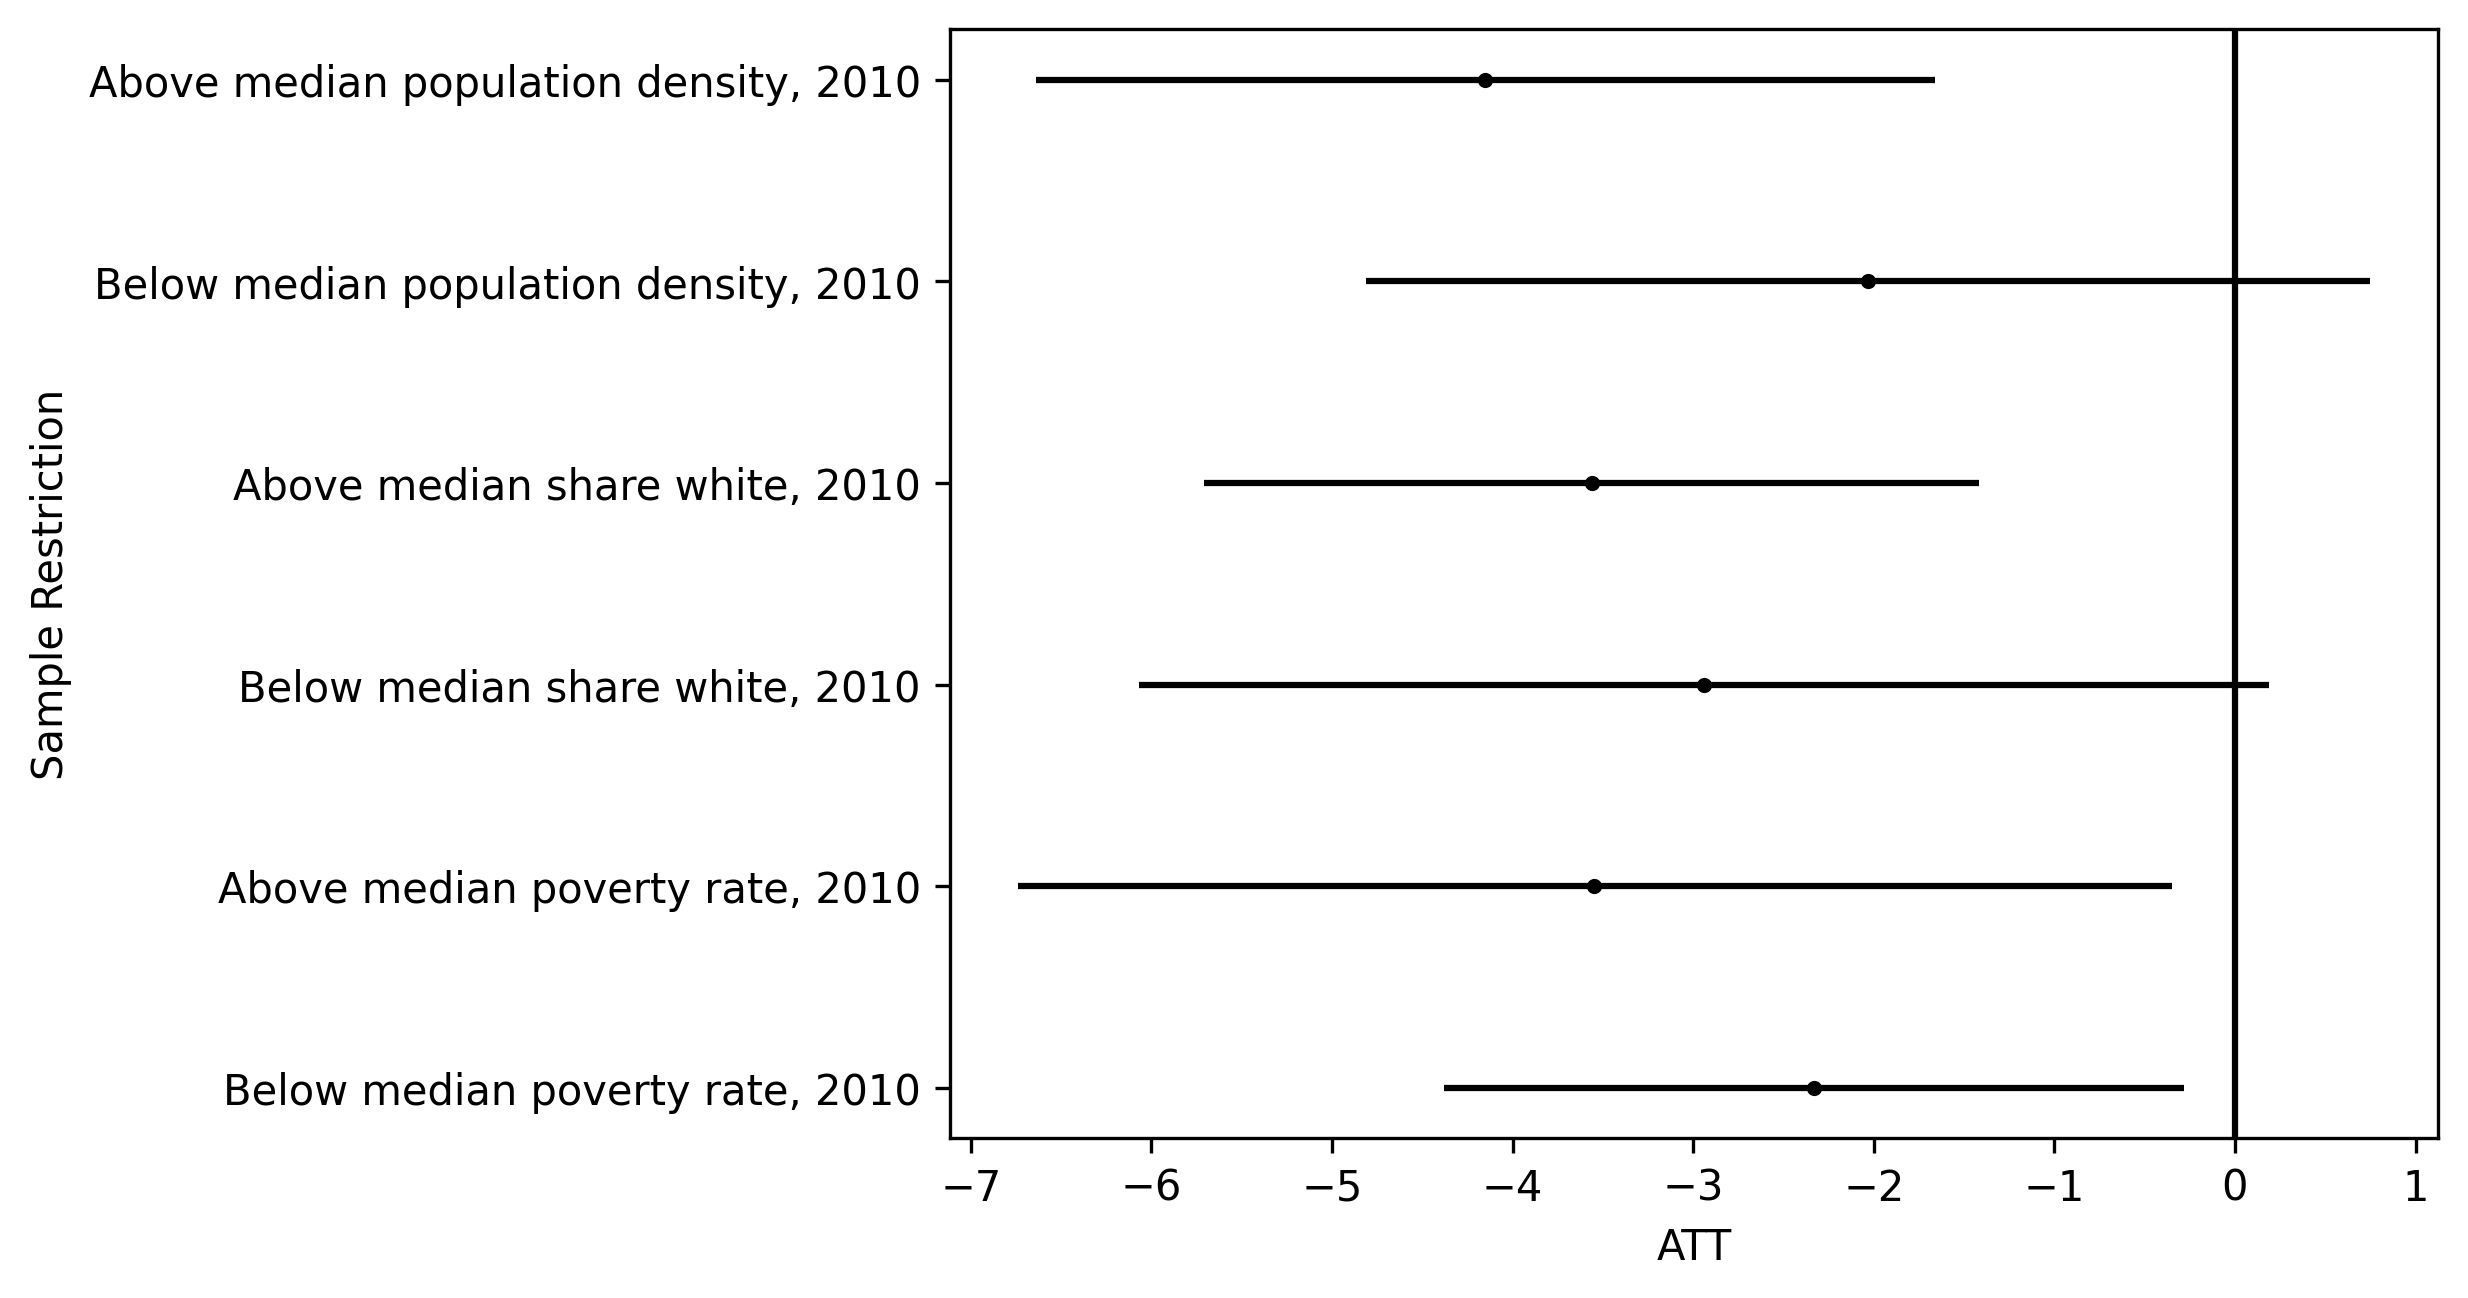

In [4]:

fig, ax = plt.subplots()
figure_utilities.plot_labeled_vline(ax, x=0, text="", color='black', linestyle='-')

for i, (ci_lower, ci_upper) in enumerate(zip(ci_lowers, ci_uppers)):
    ax.hlines(y=i, xmin=ci_lower, xmax=ci_upper, color='black')
ax.scatter(point_estimates, range(len(point_estimates)), color='black', s=7)
ax.set_yticks(ticks=range(len(point_estimates)), labels=["Below median poverty rate, 2010", "Above median poverty rate, 2010",
                                                         "Below median share white, 2010", "Above median share white, 2010",
                                                         "Below median population density, 2010", "Above median population density, 2010"])
ax.set_ylabel("Sample Restriction")
ax.set_xlabel("ATT")

figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "heterogenous_effects.png"))


# Mechanisms

## Placebo Test

In [ ]:
# Read fresh copy of unrestricted dataset into memory.
df = pd.read_parquet(INPUT_DATA_PANEL)
treatment_date_variable = 'latest_docket_month'  # Store treatment date variable.
analysis = 'group_1_crimes_500m'

In [ ]:
# Generate value variables list and dictionaries mapping between months and integers.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [ ]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable)
covariates_exploration_df

In [ ]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df)
balance_table

In [ ]:
# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [ ]:
# Run DiD conditional on covariates.
att_gt_placebo_crimes = ATTgt(data=df, cohort_name=treatment_date_variable, base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt_placebo_crimes.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)

In [ ]:
# Plot D.R. ATT(t-g)s for placebo crimes next to D.R. ATT(t-g)s for all crimes.
fig, (ax1, ax2) = plt.subplots(1, 2, layout='constrained', sharey=True)

figure_utilities.aggregate_by_event_time_and_plot(att_gt_all_crimes, start_period=-6,
                                                  end_period=36,
                                                  title="All Crime Incidents as Outcome", ax=ax1)
figure_utilities.aggregate_by_event_time_and_plot(att_gt_placebo_crimes, start_period=-6,
                                                  end_period=36,
                                                  title="Subset of Crime Incidents as Outcome", ax=ax2)

figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_placebo_crimes.png"))


## Estimation on Cases Concluding During Warm vs. Cold Months

In [ ]:
# Read fresh copy of unrestricted dataset into memory; limit to warm months
df = pd.read_parquet(INPUT_DATA_PANEL)
warm_months = ['2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10']
df = df.loc[df['latest_docket_month'].isin(warm_months), :]
treatment_date_variable = 'latest_docket_month'  # Store treatment date variable.
analysis = 'group_0_crimes_500m'

In [ ]:
# Generate value variables list and dictionaries mapping between months and integers.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [ ]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable)
covariates_exploration_df

In [ ]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df)
balance_table

In [ ]:
# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [ ]:
# Run DiD conditional on covariates.
att_gt_warm = ATTgt(data=df, cohort_name=treatment_date_variable, base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt_warm.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)

In [ ]:
# Read fresh copy of unrestricted dataset into memory; limit to warm months
df = pd.read_parquet(INPUT_DATA_PANEL)
cold_months = ['2019-04', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03']
df = df.loc[df['latest_docket_month'].isin(cold_months), :]
treatment_date_variable = 'latest_docket_month'  # Store treatment date variable.
analysis = 'group_0_crimes_500m'

In [ ]:
# Generate value variables list and dictionaries mapping between months and integers.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [ ]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable)
covariates_exploration_df

In [ ]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df)
balance_table

In [ ]:
# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [ ]:
# Run DiD conditional on covariates.
att_gt_cold = ATTgt(data=df, cohort_name=treatment_date_variable, base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt_cold.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)

In [ ]:
# Plot D.R. ATT(t-g)s for placebo crimes next to D.R. ATT(t-g)s for all crimes.
fig, (ax1, ax2) = plt.subplots(1, 2, layout='constrained', sharey=True)

figure_utilities.aggregate_by_event_time_and_plot(att_gt_warm, start_period=-6,
                                                  end_period=36,
                                                  title="Cases Concluding in\nMay 2019-October 2019", ax=ax1)
figure_utilities.aggregate_by_event_time_and_plot(att_gt_cold, start_period=-6,
                                                  end_period=36,
                                                  title="Cases Concluding in\nNovember 2019-April 2020", ax=ax2)

figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_temperature.png"))


# Robustness

In [ ]:
# Read fresh copy of unrestricted dataset into memory.
df = pd.read_parquet(INPUT_DATA_PANEL)
treatment_date_variable = 'latest_docket_month'  # Store treatment date variable.
analysis = 'group_0_crimes_500m'

In [ ]:
# Generate value variables list and dictionaries mapping between months and integers.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [ ]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            output_directory=OUTPUT_TABLES)
covariates_exploration_df

In [ ]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

In [ ]:
# Prepare df for use with the differences package.
df = df.reset_index()
df = df.loc[df['non_payment'] == 1, :]
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)



In [ ]:
# Run DiD conditional on covariates.
att_gt_non_payment = ATTgt(data=df, cohort_name=treatment_date_variable, base_period='universal')
pre_treatment_covariates.remove('non_payment')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt_non_payment.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)

In [ ]:
# Plot D.R. ATT(t-g)s on a long horizon.
fig, ax = plt.subplots(layout='constrained')
figure_utilities.aggregate_by_event_time_and_plot(att_gt_non_payment, start_period=-6,
                                                  end_period=36,
                                                  title="", ax=ax)

figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_non_payment.png"))
